<a href="https://colab.research.google.com/github/danplotkin/twitter_sentiment_transformer/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [35]:
!pip install transformers==4.28.0

In [36]:
!pip install accelerate -U

In [37]:
!pip install evaluate

In [38]:
!pip install opendatasets

# Import Libraries

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
import opendatasets as od
from collections import Counter
from tqdm.auto import tqdm
from google.colab import drive
drive.mount('/content/drive')

import torch
from sklearn.metrics import classification_report
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
import evaluate

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# download dataset
od.download('https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis')

Skipping, found downloaded files in "./twitter-entity-sentiment-analysis" (use force=True to force download)


# Clean Data

Below we will clean our data before preprocessing our data for our transformer.

### Load in DataFrames

In [41]:
train = pd.read_csv('/content/twitter-entity-sentiment-analysis/twitter_training.csv')
valid = pd.read_csv('/content/twitter-entity-sentiment-analysis/twitter_validation.csv')
train.shape, valid.shape

((74681, 4), (999, 4))

### Drop NULL Values and Duplicates

In [42]:
train = train.dropna().drop_duplicates()
valid = valid.dropna().drop_duplicates()
train.shape, valid.shape

((71655, 4), (999, 4))

### Rename Columns

In [43]:
new_cols = ['id', 'entity', 'label', 'text']
train.columns = new_cols
valid.columns = new_cols

new_order = ['id', 'entity', 'text', 'label']
train = train[new_order]
valid = valid[new_order]

train.columns

Index(['id', 'entity', 'text', 'label'], dtype='object')

In [44]:
train.head()

,id,entity,text,label
0,2401,Borderlands,I am coming to the borders and I will kill you...,Positive
1,2401,Borderlands,im getting on borderlands and i will kill you ...,Positive
2,2401,Borderlands,im coming on borderlands and i will murder you...,Positive
3,2401,Borderlands,im getting on borderlands 2 and i will murder ...,Positive
4,2401,Borderlands,im getting into borderlands and i can murder y...,Positive


# Plot Sentiment Distribution

In [45]:
def plot_dist(dataset, set_type):
  sent_dist = dataset['label'].value_counts().to_dict()
  X, y = sent_dist.keys(), sent_dist.values()
  plt.barh(list(X), list(y))
  plt.title(f'{set_type.capitalize()} Sentiment Distribtion')
  plt.ylabel('Emotion')
  plt.xlabel('Count')
  plt.gca().invert_yaxis()
  plt.show()

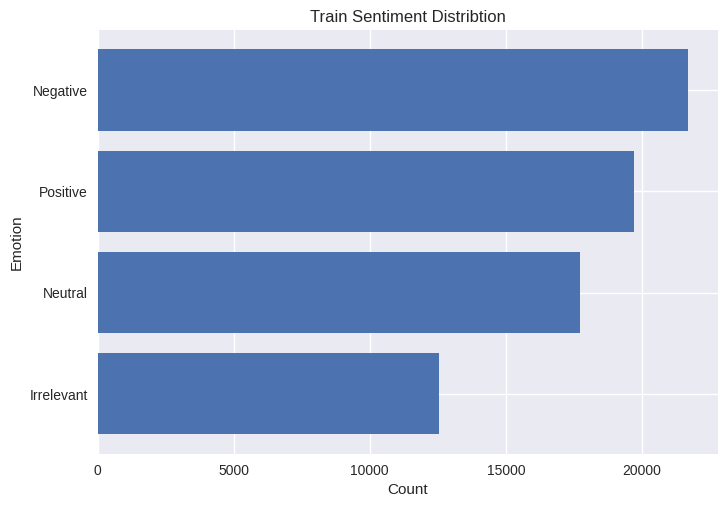

In [46]:
plot_dist(train, 'train')

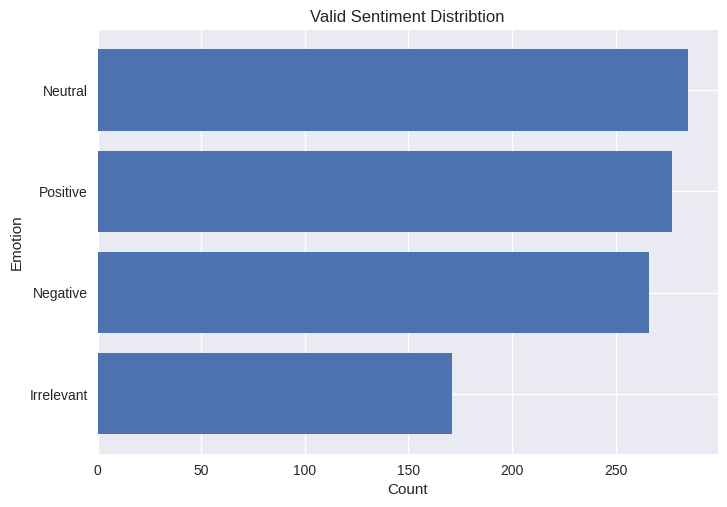

In [47]:
plot_dist(valid, 'valid')

# Preprocess Data

We will now preprocess our datasets to be in the proper format for our transformer.

### Create Label Encodings

We will create label encoding mappings so our transformer can model each class with a corresponding numeric representation.

In [48]:
# create mapping dictionaries
id2label = {idx: label for idx, label in enumerate(train['label'].unique())}
label2id = {label: idx for idx, label in id2label.items()}

In [49]:
id2label, label2id

({0: 'Positive', 1: 'Neutral', 2: 'Negative', 3: 'Irrelevant'},
 {'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3})

In [50]:
train['label'] = train['label'].map(label2id)
valid['label'] = valid['label'].map(label2id)

### Create Model Configurations

We will define our model parameters within a custom class.

In [51]:
class Config:
    model_name='distilbert-base-uncased'
    epochs=4
    batch_size=64
    n_classes=train['label'].nunique()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lr=2e-5

TOKENIZER = AutoTokenizer.from_pretrained(Config.model_name) # define tokenizer
MODEL = AutoModelForSequenceClassification.from_pretrained(
    Config.model_name,
    num_labels=Config.n_classes,
    id2label=id2label,
    label2id=label2id
).to(Config.device) # define transformer

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.

### Build Datasets

We will use the `from_pandas()` method from the `datasets.Dataset` class to structure our datasets in a dataset dictionary.

In [52]:
cols_to_drop = ['id', 'entity'] # drop irrelevent columns

train_dataset = Dataset.from_pandas(train.drop(cols_to_drop, 1).reset_index(drop=True))
val_dataset = Dataset.from_pandas(valid.drop(cols_to_drop, 1).reset_index(drop=True))
print(train_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 71655
})


### Tokenize Datasets

We will tokenize our text column in our datasets.

In [53]:
def tokenize(batch):
    return TOKENIZER(batch['text'], truncation=True)

train_encoded = train_dataset.map(tokenize, batched=True)
valid_encoded = val_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/71655 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [54]:
print(train_encoded, valid_encoded)

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 71655
}) Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 999
})


### Define Collate Function

Using Hugging Face's `DataCollatorWithPadding`, we will define a data collator that will ensure our input sequences are the same length by adding padding tokens to match the length of the longest sequence.



In [55]:
collate_fn = DataCollatorWithPadding(TOKENIZER)

### Create Accuracy Function

We will use the `evaluate` library to create a custom accuracy metric that will be used for training.

In [56]:
accuracy = evaluate.load("accuracy")

In [57]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Train Model

Below we will define our training arguments and train our model.

In [58]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Models/twitter_sentiment_model',
    num_train_epochs=Config.epochs,
    learning_rate=Config.lr,
    per_device_train_batch_size=Config.batch_size,
    per_device_eval_batch_size=Config.batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    logging_strategy='epoch'
)


trainer = Trainer(
    model=MODEL,
    args=training_args,
    data_collator=collate_fn,
    tokenizer=TOKENIZER,
    compute_metrics=compute_metrics,
    train_dataset=train_encoded,
    eval_dataset=valid_encoded
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.904400,0.528866,0.818819
2,0.520800,0.265046,0.919920
3,0.308800,0.205353,0.935936
4,0.219500,0.181636,0.950951


TrainOutput(global_step=4480, training_loss=0.4883647748402187, metrics={'train_runtime': 2426.6396, 'train_samples_per_second': 118.114, 'train_steps_per_second': 1.846, 'total_flos': 7516535552262240.0, 'train_loss': 0.4883647748402187, 'epoch': 4.0})

In [59]:
trainer.evaluate()

{'eval_loss': 0.1816364973783493,
 'eval_accuracy': 0.950950950950951,
 'eval_runtime': 2.9073,
 'eval_samples_per_second': 343.622,
 'eval_steps_per_second': 5.503,
 'epoch': 4.0}

The model is **96.5%** accuracte to new data.

In [60]:
model_path = '/content/drive/MyDrive/Models/twitter_sentiment_model_distilBERT'

In [61]:
trainer.save_model(model_path)

# View Classification Report

In [62]:
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cpu')

In [63]:
# Create a pipeline object for sequence classification
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=TOKENIZER
)

In [64]:
truths = valid['label'].map(id2label).to_list()

In [65]:
preds = []
for i, row in tqdm(valid.iterrows(), total=len(valid)):
    sample = valid['text'].to_list()[i]
    pred = classifier(sample)[0]['label']
    preds.append(pred)

  0%|          | 0/999 [00:00<?, ?it/s]

In [66]:
print(classification_report(truths, preds))

              precision    recall  f1-score   support

  Irrelevant       0.97      0.91      0.94       171
    Negative       0.97      0.95      0.96       266
     Neutral       0.92      0.97      0.94       285
    Positive       0.96      0.96      0.96       277

    accuracy                           0.95       999
   macro avg       0.95      0.95      0.95       999
weighted avg       0.95      0.95      0.95       999



# View a Few Predictions

In [75]:
first_n = 5
zipped_list = list(zip(valid['text'].to_list()[:first_n], preds[:first_n], truths[:first_n]))
for item in zipped_list:
    print(f'TEXT: {item[0]}\nPREDICTED: {item[1]} | TRUTH: {item[2]}\n')

TEXT: BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…
PREDICTED: Neutral | TRUTH: Neutral

TEXT: @Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Chromebook? 🙄
PREDICTED: Negative | TRUTH: Negative

TEXT: CSGO matchmaking is so full of closet hacking, it's a truly awful game.
PREDICTED: Negative | TRUTH: Negative

TEXT: Now the President is slapping Americans in the face that he really did commit an unlawful act after his  acquittal! From Discover on Google vanityfair.com/news/2020/02/t…
PREDICTED: Neutral | TRUTH: Neutral

TEXT: Hi @EAHelp I’ve had Madeleine McCann in my cellar for the past 13 years and the little sneaky thing just escaped whilst I was loading up some fifa points, she took my card and I’m having to use my paypal account but it isn’t working, can you help me resolve it please?
PREDICTED: Negative | TRUTH: Negative



# Plot Amazon Predicted Sentiments

In [83]:
def calculate_sentiments(entity, plot=True):
    """
    Function to view the sentiment distribution for a given entity.
    """
    data = valid[valid['entity']==entity]
    preds = []
    for i, row in data.iterrows():
        pred = classifier(row[2])[0]['label']
        preds.append(pred)
    counts = Counter(preds)
    ordered_dict = {element: count for element, count in counts.most_common()}
    if plot:
        X, y = list(ordered_dict.keys()), list(ordered_dict.values())
        plt.barh(X, y)
        plt.title(f'{entity} Sentiment Distribution')
        plt.ylabel('Sentiment')
        plt.xlabel('Counts')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        return ordered_dict

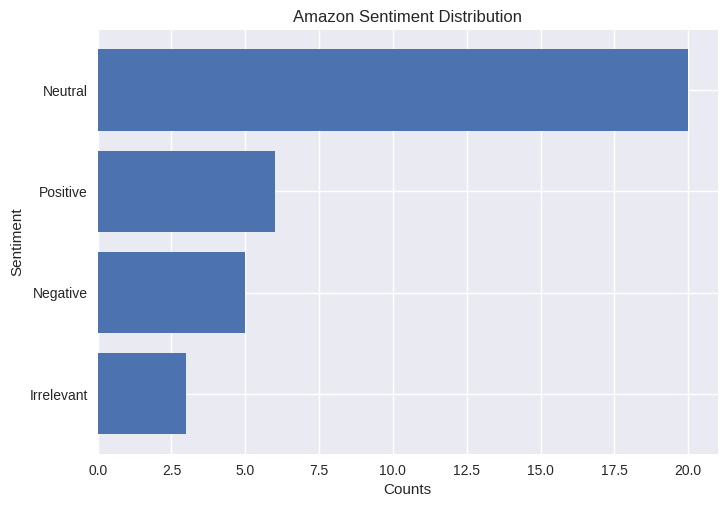

In [84]:
calculate_sentiments('Amazon')